<a href="https://colab.research.google.com/github/akashsonowal/aqi-analysis-and-forecasting/blob/main/aqi_analysis_and_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Part 1: Brief analysis of COVID-19's impact on India's AQI**

The air quality index (AQI) is an index for reporting air quality on a daily basis. 

A low AQI indicates good air quality and low levels of pollution while a higher AQI suggests increased concentrations of pollutants in the air which is extremely detrimental to human health.

**The air quality index is composed of 8 pollutants (PM10, PM2.5, NO2, SO2, CO, O3, NH3, and Pb)**

AQI scores and categories:

- Good (0–50)
- Satisfactory (51–100)
- Moderately polluted (101–200)
- Poor (201–300)
- Very poor (301–400)
- Severe (401–500)

We will be using the day-wise AQI dataset which contains information regarding the daily level of pollutants and AQI in around 26 Indian cities from 2015-2020.

Our notebook has two major parts:

1. Finding the most polluted cities in recent years and analysing the levels of pollutants here. Understanding the impact of COVID-19 induced lockdowns on Air Quality in some of the major cities : analysing which cities underwent the most drastic improvement in Air Quality and which cities showed a spike in AQI levels inspite of a stringent lockdown

2. We do a time-series analysis of the data and and fit a SARIMA model with computed orders to forecast India's AQI in 2021.

In [2]:
import numpy as np 
import pandas as pd 

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings('ignore')

In [3]:
#importing day-wise data of cities
cities= pd.read_csv('/content/drive/MyDrive/Projects/06. AQI  Analysis & Forecasting/datasets/city_day.csv')

#visualizing the top rows of the dataset
cities.head()

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
1,Ahmedabad,2015-01-02,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2,Ahmedabad,2015-01-03,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
3,Ahmedabad,2015-01-04,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
4,Ahmedabad,2015-01-05,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


In [4]:
#getting information about the columns in our dataset
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29531 entries, 0 to 29530
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   City        29531 non-null  object 
 1   Date        29531 non-null  object 
 2   PM2.5       24933 non-null  float64
 3   PM10        18391 non-null  float64
 4   NO          25949 non-null  float64
 5   NO2         25946 non-null  float64
 6   NOx         25346 non-null  float64
 7   NH3         19203 non-null  float64
 8   CO          27472 non-null  float64
 9   SO2         25677 non-null  float64
 10  O3          25509 non-null  float64
 11  Benzene     23908 non-null  float64
 12  Toluene     21490 non-null  float64
 13  Xylene      11422 non-null  float64
 14  AQI         24850 non-null  float64
 15  AQI_Bucket  24850 non-null  object 
dtypes: float64(13), object(3)
memory usage: 3.6+ MB


To be able to construct time plots, we need to first convert the Date column into a DateTime format.

In [5]:
print(cities.shape)

#converting column Date into DateTime format
cities['Date']=pd.to_datetime(cities['Date'])

(29531, 16)


Next, we try to find the percentage of missing values in each column.

            Proportion
Xylene        0.613220
PM10          0.377231
NH3           0.349734
Toluene       0.272290
Benzene       0.190410
AQI           0.158511
AQI_Bucket    0.158511
PM2.5         0.155701
NOx           0.141715
O3            0.136196
SO2           0.130507
NO2           0.121398
NO            0.121296
CO            0.069723
City          0.000000
Date          0.000000


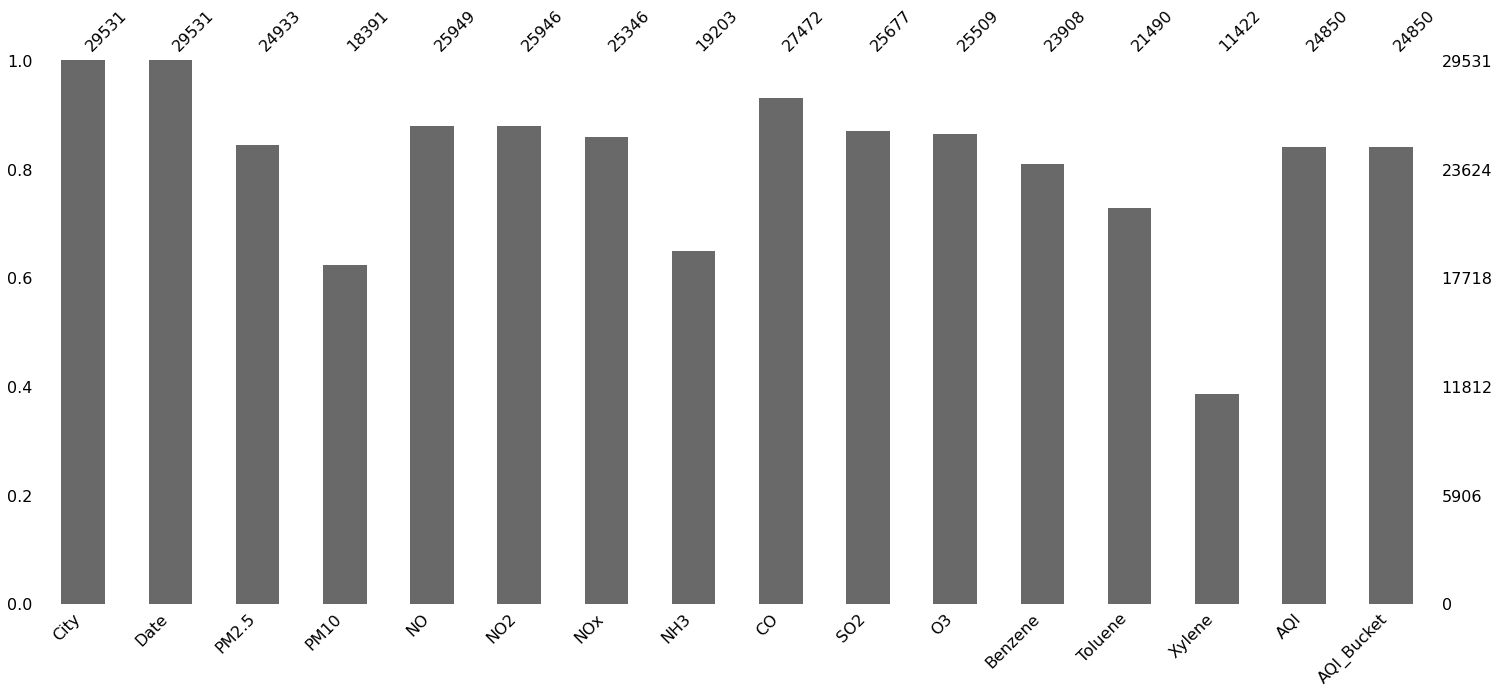

In [6]:
import missingno as msno
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#finding the proportion of missing values in each column
missing=pd.DataFrame(cities.isna().sum()/len(cities))
missing.columns=['Proportion']
print(missing.sort_values(by='Proportion', ascending=False))

#plotting the number of non-null values in each column
msno.bar(cities)

We see that Xylene and PM10 have a very high proportion of missing values. This might be due to manual inconsistencies/human negligence while recording or absence of enough stations in the city.

Next, processing our dataset further and for ease of analysis, we club columns of the same category together.

In [7]:
#filling missing values with zero - can also be imputed by mean of the observations
cities.fillna(0,inplace=True)

#extracting year and month for each record
cities['year'] = pd.DatetimeIndex(cities['Date']).year
cities['month'] = pd.DatetimeIndex(cities['Date']).month

#clubbing all particulate matter
cities['PM']=cities['PM2.5'] + cities['PM10']

#clubbing nitrogen oxides
cities['Nitric']=cities['NO'] + cities['NO2']+ cities['NOx']

#clubbing Benzene, toluene and Xylene together
cities['BTX']=cities['Benzene'] + cities['Toluene']+ cities['Xylene']

#grouping pollutant levels in every city by year and month
cities_group_ym=cities.groupby(['City','year','month'])[['PM','Nitric','CO','NH3','O3','SO2','BTX','AQI']].mean()

cities_group_ym=cities_group_ym.reset_index(['City','year','month'])
cities_group_ym.head()

,City,year,month,PM,Nitric,CO,NH3,O3,SO2,BTX,AQI
0,Ahmedabad,2015,1,10.668710,88.680000,22.352258,0.0,46.350645,43.602903,6.971613,33.903226
1,Ahmedabad,2015,2,103.662143,92.985714,19.482143,0.0,43.437857,56.423214,35.357143,464.857143
2,Ahmedabad,2015,3,106.905806,80.510000,13.585484,0.0,44.276774,56.975161,41.357419,378.064516
3,Ahmedabad,2015,4,101.682000,54.992667,7.306333,0.0,31.376000,51.233333,14.496333,257.200000
4,Ahmedabad,2015,5,74.919355,50.607419,8.529677,0.0,31.624194,35.977419,19.677419,254.967742


**Visualizing the most polluted cities for each category of pollutants (2017-19)**

We take years 2017-2019 as our reference years to understand the general trend of pollutants prevailing in some of the most polluted Indian cities:

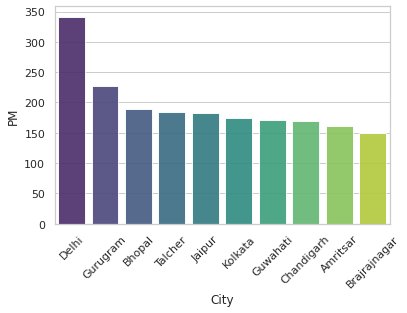

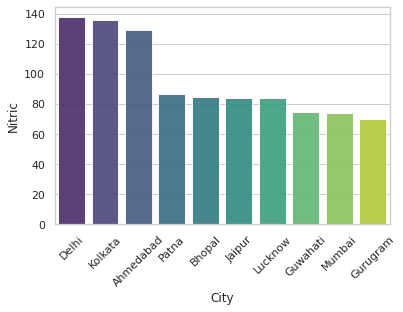

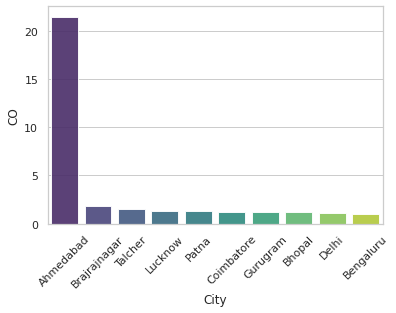

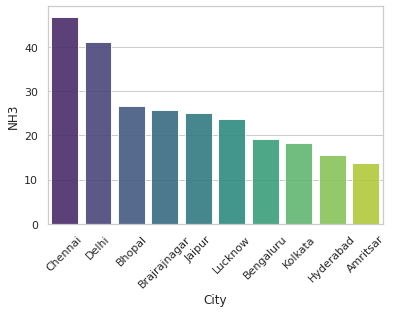

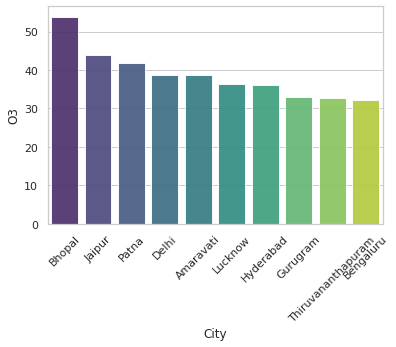

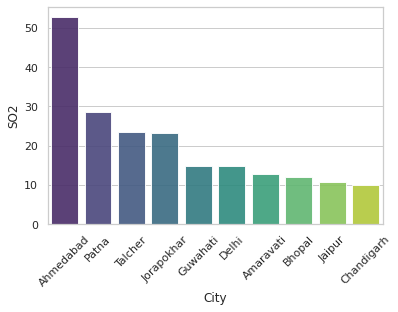

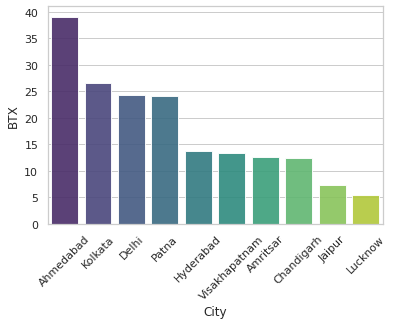

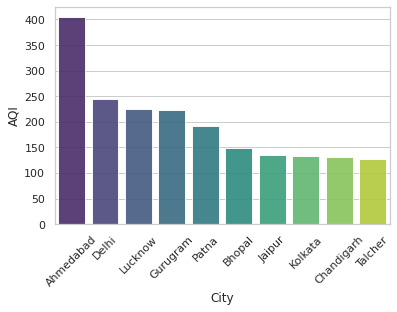

In [8]:
#taking a subset of our dataset for the last three years before 2020
cities_17_19=cities_group_ym[cities_group_ym['year'].isin([2017,2018,2019])]

#list of pollutants
pollutants=['PM','Nitric','CO','NH3','O3','SO2','BTX','AQI']
sns.set_theme(style='whitegrid')

#plotting the top 10 most polluted cities for each category of pollutants, as well as overall AQI
for i in pollutants:
    df=cities_17_19.groupby(['City'])[[i]].mean().sort_values(i,ascending=False).iloc[:10,:]
    df=df.reset_index(['City'])
    plt.figure()
    sns.barplot(data=df, x="City", y=i, palette="viridis", alpha=.9)
    plt.xticks(rotation=45) 

Now, we try to find how each individual pollutant is related to the AQI.

              PM    Nitric        CO  ...       SO2       BTX       AQI
PM      1.000000  0.626912 -0.001708  ...  0.194107  0.170518  0.589689
Nitric  0.626912  1.000000  0.351381  ...  0.398588  0.297628  0.660347
CO     -0.001708  0.351381  1.000000  ...  0.658116  0.342239  0.672568
NH3     0.273868  0.205231 -0.107090  ... -0.089157  0.016164  0.088668
O3      0.414142  0.336590  0.112073  ...  0.298710  0.207562  0.404758
SO2     0.194107  0.398588  0.658116  ...  1.000000  0.339907  0.591202
BTX     0.170518  0.297628  0.342239  ...  0.339907  1.000000  0.348172
AQI     0.589689  0.660347  0.672568  ...  0.591202  0.348172  1.000000

[8 rows x 8 columns]


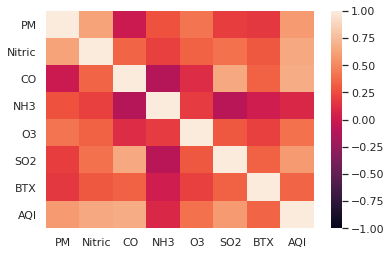

In [9]:
#plotting the correlation matrix with sns heatmap
corr_matrix = cities_group_ym.iloc[:,3:].corr()
print(corr_matrix)
fig = plt.figure(figsize = (6, 4))
sns.heatmap(corr_matrix, vmin=-1, vmax=1)
plt.show()

We see that BTX has the lowest correlation with AQI- which is perfectly in sync with the AQI calculation formula. The air quality index is composed of 8 pollutants ((PM10, PM2.5, NO2, SO2, CO, O3, NH3, and Pb), but does not directly account for BTX.

Next, we study the general AQI trend over the months from year 2017-19.

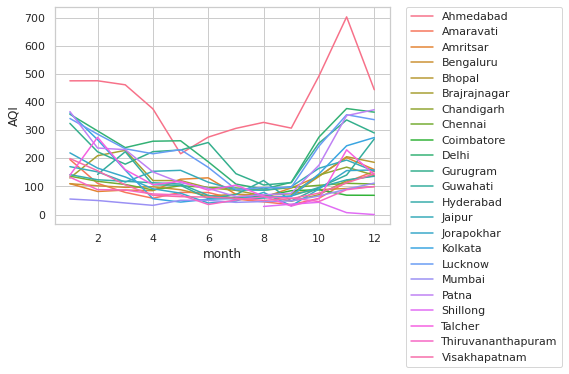

In [10]:
df_AQI_trend= cities_17_19.groupby(['City','month'])[['AQI']].mean().reset_index()
sns.lineplot(data=df_AQI_trend,x="month", y="AQI",hue='City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

We see that there is a clear pattern which emerges here. AQI decreases in the summer months, which in turn means that air quality improves over these months.

**Analysing the impact of COVID-19 induced lockdown on AQI:**

To start off, we will be picking out some cities from the most polluted ones(as inferred above) and try to visualize how their AQI changed in 2020 as compared to 2019.

Here onwards, we will be doing our analysis and inferencing based on percentage change in AQI from 2019 to 2020.

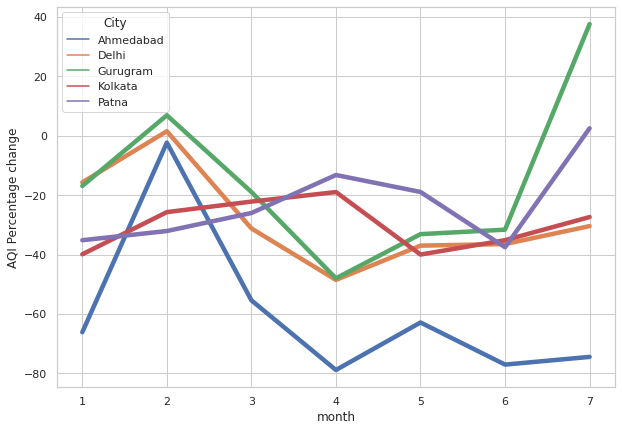

In [11]:
#creating a list of some of the most polluted cities
most_polluted=['Delhi','Patna','Ahmedabad','Gurugram','Kolkata']

#forming two df's- containing data from 2019 and 2020 respectively
cities_2019= cities_group_ym[(cities_group_ym['City'].isin(most_polluted)) & (cities_group_ym['year']==2019)]
cities_2020= cities_group_ym[(cities_group_ym['City'].isin(most_polluted)) & (cities_group_ym['year']==2020)]

cities_19_vs_20 = pd.merge(cities_2019, cities_2020, how="inner", on=["City", "month"])
#computing the percentage change in AQI
cities_19_vs_20['AQI Percentage change']=100*(cities_19_vs_20['AQI_y']-cities_19_vs_20['AQI_x'])/cities_19_vs_20['AQI_x']

#plotting AQI change for a few highly polluted cities
fig = plt.figure(figsize=(10,7))
sns.lineplot(data=cities_19_vs_20,x="month", y="AQI Percentage change",hue='City',linewidth=4.5,markers=True, dashes=False)

The general trend shows that the AQI indeed decreased for the lockdown months, signifying a major improvement in Air quality with reduced pollution levels.

However, we will now investigate the cities which fared the best in these 4 months and also the ones which showed anomalies with a spike in AQI.

**Cities which had underwent the most drastic improvement in Air Quality:**

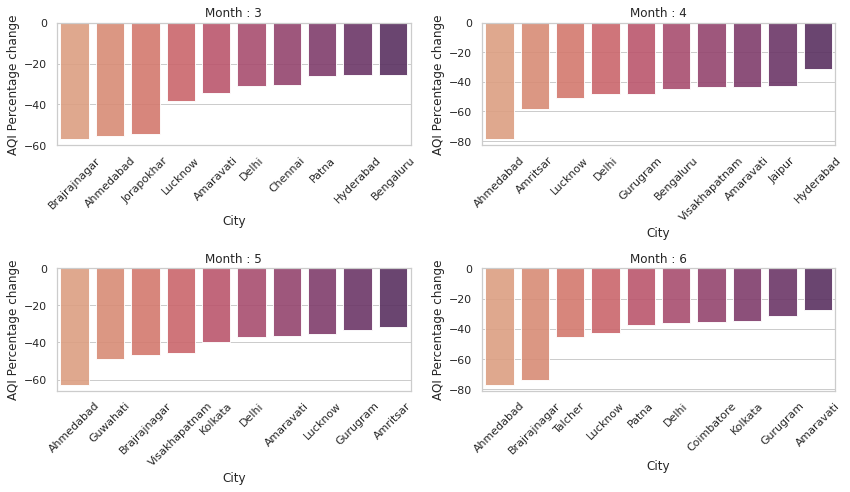

In [12]:
#forming two seperate dataframes for years 2019 and 2020
cities_19_all= cities_group_ym[cities_group_ym['year']==2019]
cities_20_all= cities_group_ym[cities_group_ym['year']==2020]

#joining the two df's to get a comparitive view of AQI value in 2019 and 2020
cities_19_vs_20_all = pd.merge(cities_19_all, cities_20_all, how="inner", on=["City", "month"])
cities_19_vs_20_all['AQI Percentage change']=100*(cities_19_vs_20_all['AQI_y']-cities_19_vs_20_all['AQI_x'])/cities_19_vs_20_all['AQI_x']

#lockdown months- which we will be analysing
months=[3,4,5,6]
fig, axes = plt.subplots(ncols=2, nrows=2,figsize=(12, 7))

#plotting the top 10 cities for the months March-June 2020 which had the most improvement in AQI
for i, ax in zip(months, axes.flat):
    cities_AQI_comp=cities_19_vs_20_all[(cities_19_vs_20_all['AQI_y']!= 0.000000) & (cities_19_vs_20_all['month']==i)]
    cities_AQI_comp_10=cities_AQI_comp[['City','month','AQI_x','AQI_y','AQI Percentage change']].sort_values(by='AQI Percentage change', ascending=True).iloc[:10,:]
    h=sns.barplot(data=cities_AQI_comp_10, x="City", y='AQI Percentage change', palette="flare", alpha=.9, ax=ax)
    h.set(title='Month : {}'.format(i))
    h.set_xticklabels(h.get_xticklabels(), rotation=45)
    
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

We can see that there has been a significant improvement in the air quality for these cities over the four months.

**Cities which showed an increased AQI as compared to 2019 in the lockdown-months:**

Analysing the cities which showed a positive AQI change percentage, denoting an increased AQI in 2020:

In [13]:
#finding cities which have a higher AQI in months March April, May, June of 2020 as compared to the same months last year
cities_19_vs_20_all[(cities_19_vs_20_all['AQI Percentage change']>=0)&(cities_19_vs_20_all['month'].isin([3,4,5,6]) )][['City','month','AQI_x','AQI_y','AQI Percentage change']].sort_values(by='AQI Percentage change', ascending=False)

,City,month,AQI_x,AQI_y,AQI Percentage change
83,Jorapokhar,6,0.000000,136.533333,inf
125,Thiruvananthapuram,6,28.266667,45.400000,60.613208
60,Guwahati,4,105.933333,127.833333,20.673379
82,Jorapokhar,5,113.709677,135.580645,19.234043
31,Brajrajnagar,4,101.633333,119.533333,17.612332
116,Talcher,4,118.466667,127.733333,7.822172
81,Jorapokhar,4,113.833333,121.400000,6.647145


Analysing in detail the towns/cities which recorded a higher AQI in April and May of 2020 as compared to 2019:

Guwahati :


<Figure size 432x288 with 0 Axes>

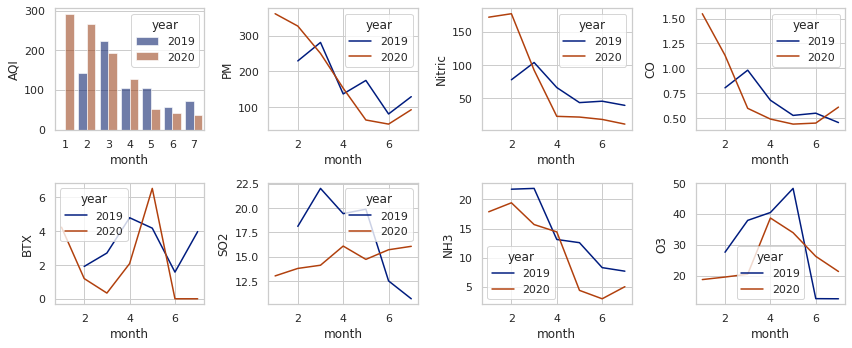

Jorapokhar :


<Figure size 432x288 with 0 Axes>

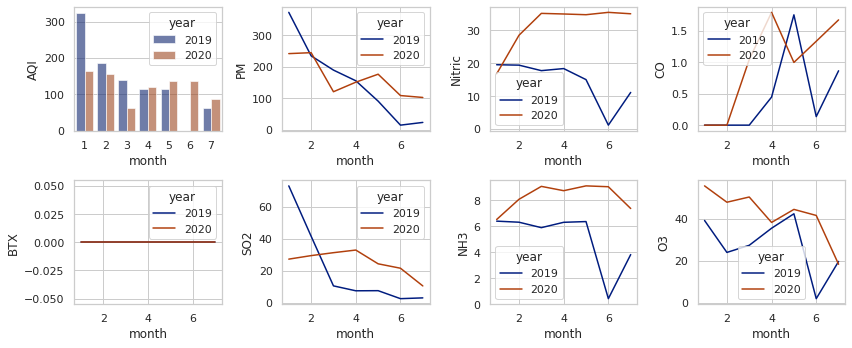

Brajrajnagar :


<Figure size 432x288 with 0 Axes>

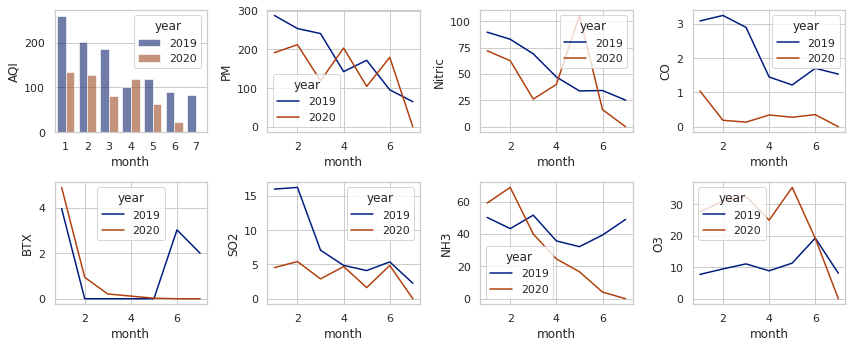

Talcher :


<Figure size 432x288 with 0 Axes>

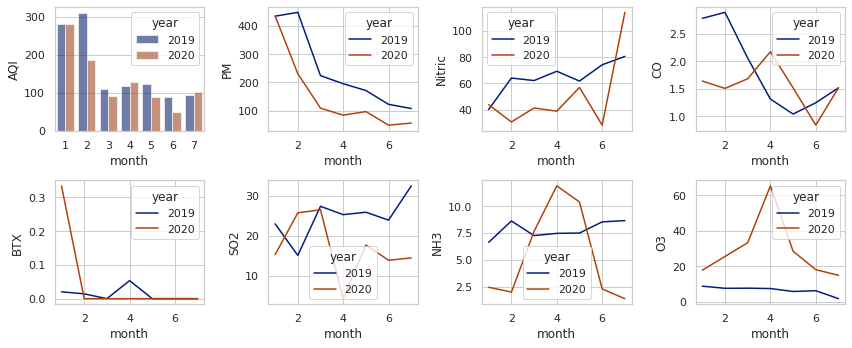

In [14]:
#cities displayed above which showed a higher AQI in the lockdown months of 2020 as compared to 2019
anomalies=['Guwahati','Jorapokhar','Brajrajnagar','Talcher']

#understanding the rise of pollutants which contributed to the increased AQI in 2020 by comparing the levels of each pollutant in 2019 and 2020
for i in anomalies:
    city_19_20= cities_group_ym[(cities_group_ym['City']==i) & (cities_group_ym['year'].isin([2019,2020]))&(cities_group_ym['month']<8)]

    sns.set_theme(style="whitegrid")
    fig = plt.figure()
    fig, axes = plt.subplots(2,4,figsize=(12, 5))
    
    sns.barplot(data=city_19_20, x="month", y="AQI", hue="year",palette="dark", alpha=.6,ax=axes[0,0])
    sns.lineplot(data=city_19_20, x="month", y="PM", hue="year",palette='dark',markers=True, dashes=False,ax=axes[0,1])
    sns.lineplot(data=city_19_20, x="month", y="Nitric", hue="year",palette='dark', markers=True, dashes=False,ax=axes[0,2])
    sns.lineplot(data=city_19_20, x="month", y="CO", hue="year",palette='dark', markers=True, dashes=False,ax=axes[0,3])
    sns.lineplot(data=city_19_20,x="month", y="BTX", hue="year",palette='dark', markers=True, dashes=False,ax=axes[1,0])
    sns.lineplot(data=city_19_20, x="month", y="SO2", hue="year",palette='dark', markers=True, dashes=False,ax=axes[1,1])
    sns.lineplot(data=city_19_20, x="month", y="NH3", hue="year",palette='dark', markers=True,ax=axes[1,2])
    sns.lineplot(data=city_19_20, x="month", y="O3", hue="year",palette='dark', markers=True, ax=axes[1,3])
    fig.tight_layout()
    print(i,':')
    plt.show()

We see that the four cities mentioned above did not witness an improvement in AQI during the COVID-19 induced lockdown as expected. The reason might be manifold: sparse AQI readings in 2020,flouting of lockdown norms, or any other natural phenomenon overriding the positive impact of decreased human and industrial activity.

* Guwahati: we see that AQI for April'20 is more than 20% higher as compared to April'19. Particulate matter and NH3 were the increased contributing factors
* Jorapokhar: we see that AQI for May'20 is substantially higher as compared to May'19. Concentration of almost all pollutants have increased
* Brajrajnagar: Higher AQI in April'20 as compared to April'19. Can be attributed to increased O3 and PM levels
* Talcher:Higher AQI in April'20 as compared to April'19. Can be attributed to increased CO,O3 and NH3 levels

## **Part 2: Time Series Forecasting with SARIMA**

In [15]:
#importing day-wise data of cities
df= pd.read_csv('/content/drive/MyDrive/Projects/06. AQI  Analysis & Forecasting/datasets/city_day.csv')

df['Date'] = pd.to_datetime(df['Date'])

#visualizing the top rows of the dataset
df.tail(5)

,City,Date,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
29526,Visakhapatnam,2020-06-27,15.02,50.94,7.68,25.06,19.54,12.47,0.47,8.55,23.30,2.24,12.07,0.73,41.0,Good
29527,Visakhapatnam,2020-06-28,24.38,74.09,3.42,26.06,16.53,11.99,0.52,12.72,30.14,0.74,2.21,0.38,70.0,Satisfactory
29528,Visakhapatnam,2020-06-29,22.91,65.73,3.45,29.53,18.33,10.71,0.48,8.42,30.96,0.01,0.01,0.00,68.0,Satisfactory
29529,Visakhapatnam,2020-06-30,16.64,49.97,4.05,29.26,18.80,10.03,0.52,9.84,28.30,0.00,0.00,0.00,54.0,Satisfactory
29530,Visakhapatnam,2020-07-01,15.00,66.00,0.40,26.85,14.05,5.20,0.59,2.10,17.05,NaN,NaN,NaN,50.0,Good


We pivot the values from the 'City' column, so that we can have a comparitive view of the value of every city's AQI through every day.

Then we resample them to find the mean of every month, so now our dataset contains month-wise data.

In [16]:
cities_all = df.pivot_table(values='AQI', index=['Date'], columns='City')
cities_all=cities_all.add_suffix('_AQI')
cities=cities_all.resample(rule='MS').mean()
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,Delhi_AQI,Ernakulam_AQI,Gurugram_AQI,Guwahati_AQI,Hyderabad_AQI,Jaipur_AQI,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,350.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.290323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-01,520.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.928571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-01,418.571429,NaN,NaN,NaN,130.545455,NaN,NaN,NaN,363.800000,NaN,256.064516,NaN,NaN,NaN,120.000000,NaN,NaN,NaN,NaN,264.272727,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-01,308.640000,NaN,NaN,NaN,113.733333,NaN,NaN,NaN,175.862069,NaN,305.266667,NaN,NaN,NaN,140.807692,NaN,NaN,NaN,NaN,118.586207,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-01,263.466667,NaN,NaN,NaN,102.774194,NaN,NaN,NaN,176.129032,NaN,348.580645,NaN,NaN,NaN,133.387097,NaN,NaN,NaN,NaN,137.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#form a new column containing India's AQI for every month by taking the average of all cities for that month
cities['India_AQI']=cities.mean(axis=1)
cities.head()

City,Ahmedabad_AQI,Aizawl_AQI,Amaravati_AQI,Amritsar_AQI,Bengaluru_AQI,Bhopal_AQI,Brajrajnagar_AQI,Chandigarh_AQI,Chennai_AQI,Coimbatore_AQI,Delhi_AQI,Ernakulam_AQI,Gurugram_AQI,Guwahati_AQI,Hyderabad_AQI,Jaipur_AQI,Jorapokhar_AQI,Kochi_AQI,Kolkata_AQI,Lucknow_AQI,Mumbai_AQI,Patna_AQI,Shillong_AQI,Talcher_AQI,Thiruvananthapuram_AQI,Visakhapatnam_AQI,India_AQI
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01,350.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,342.290323,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,346.311828
2015-02-01,520.640000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.928571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424.284286
2015-03-01,418.571429,NaN,NaN,NaN,130.545455,NaN,NaN,NaN,363.800000,NaN,256.064516,NaN,NaN,NaN,120.000000,NaN,NaN,NaN,NaN,264.272727,NaN,NaN,NaN,NaN,NaN,NaN,258.875688
2015-04-01,308.640000,NaN,NaN,NaN,113.733333,NaN,NaN,NaN,175.862069,NaN,305.266667,NaN,NaN,NaN,140.807692,NaN,NaN,NaN,NaN,118.586207,NaN,NaN,NaN,NaN,NaN,NaN,193.815995
2015-05-01,263.466667,NaN,NaN,NaN,102.774194,NaN,NaN,NaN,176.129032,NaN,348.580645,NaN,NaN,NaN,133.387097,NaN,NaN,NaN,NaN,137.000000,NaN,NaN,NaN,NaN,NaN,NaN,193.556272


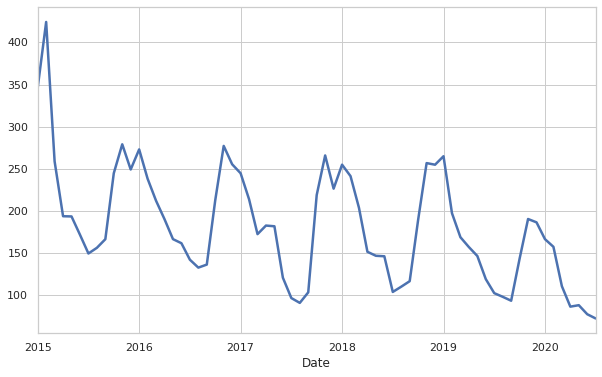

In [18]:
cities.reset_index()
sns.set_theme(style='whitegrid')
#plot India's AQI
cities['India_AQI'].plot(kind='line',grid=True,figsize=(10, 6), linewidth=2.5)

From the plot above, we can visually see that there is a slight downward trend and a seasonality present. However, we will decompose the plot into trend, seasonality and residuals to get a clearer picture.

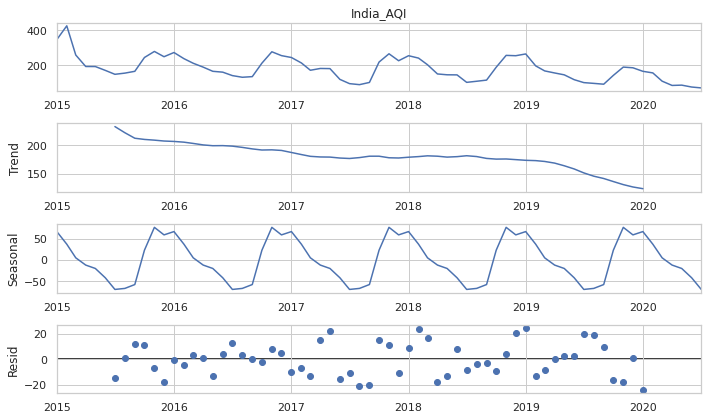

In [19]:
plt.rcParams['figure.figsize'] = (10, 6);
cities['India_AQI']=cities.mean(axis=1)
fig = seasonal_decompose(cities['India_AQI'], model='additive').plot()

We can see a clear seasonality and trend present here. The AQI decreases towards mid-year before rising again.

**Augmented Dicky Fuller Test:**

We'll perform the ADF for determining stationarity of the time series.

In [20]:
dftest = adfuller(cities['India_AQI'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                 -0.114224
p-value                         0.948003
#Lags Used                     10.000000
Number of Observations Used    56.000000
Critical Value (1%)            -3.552928
Critical Value (5%)            -2.914731
Critical Value (10%)           -2.595137
dtype: float64

The p-value is 0.94, which means that this time series is not stationary.
We perform a first order differencing to remove the trend and then perform the ADF test again.

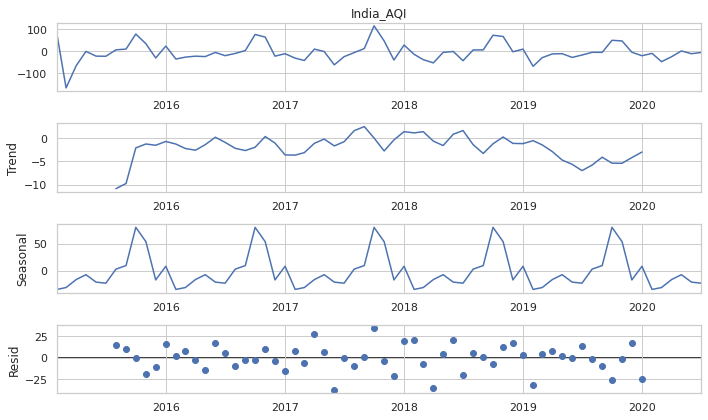

In [21]:
diff = cities['India_AQI'].diff(periods=1)
diff.dropna(inplace=True)
fig = seasonal_decompose(diff, model='additive').plot()

In [22]:
dftest = adfuller(diff)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
dfoutput

Test Statistic                -8.385232e+00
p-value                        2.448599e-13
#Lags Used                     9.000000e+00
Number of Observations Used    5.600000e+01
Critical Value (1%)           -3.552928e+00
Critical Value (5%)           -2.914731e+00
Critical Value (10%)          -2.595137e+00
dtype: float64

From the p-value and the Test Statistic, we can conclude that with one differencing, the time series becomes stationary. Therefore, d=1.

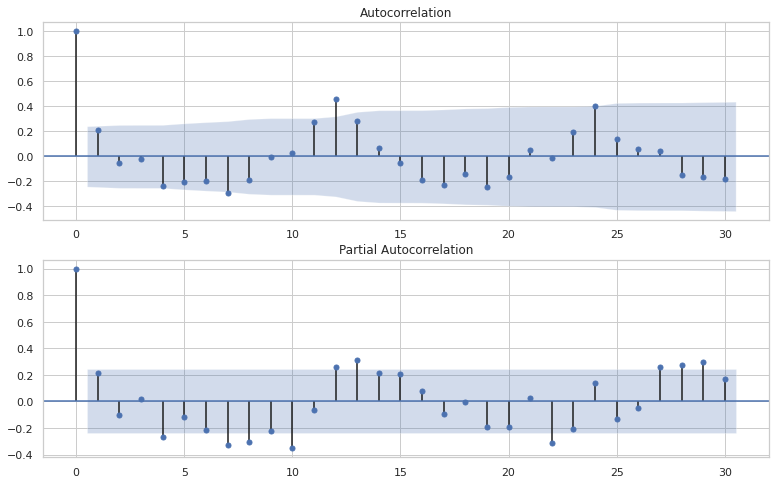

In [23]:
fig, ax = plt.subplots(2,figsize=(13, 8))
ax[0] = plot_acf(diff, lags=30, ax=ax[0])
ax[1] = plot_pacf(diff,lags=30, ax=ax[1])

We can use auto-arima to determine the parameters of the SARIMA model.

In [24]:
#installing pmdarima
!pip install pmdarima

In [25]:
from pmdarima import auto_arima; 

In [26]:
auto_arima(y=cities['India_AQI'],start_p=1,start_P=1,start_q=1,start_Q=1,seasonal=True,m=12, stepwise=True).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                   67
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -316.908
Date:                              Sun, 15 Aug 2021   AIC                            643.816
Time:                                      09:51:00   BIC                            654.765
Sample:                                           0   HQIC                           648.143
                                               - 67                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0189      0.059      0.320      0.749      -0.097       0.135
ma.L2         -0.8363      0.069    -12.077      0.000      -0.972      -0.701
ar.S.L12       0.9444      0.062     15.221      0.000       0.823       1.066
ma.S.L12      -0.5623      0.229     -2.458      0.014      -1.011      -0.114
sigma2       694.3699    142.982      4.856      0.000     414.130     974.610
===================================================================================
Ljung-Box (L1) (Q):                   0.95   Jarque-Bera (JB):                 2.99
Prob(Q):                              0.33   Prob(JB):                         0.22
Heteroskedasticity (H):               0.38   Skew:                            -0.52
Prob(H) (two-sided):                  0.03   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
#dividing into train and test:
train_data=cities['India_AQI'][:'2018-12']
test_data=cities['India_AQI'][:'2019-12']

#Building the model:
model=SARIMAX(train_data,order=(0,1,2),seasonal_order=(1,0,1,12), trend='n')
results=model.fit()

#printing summry of model reults
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            India_AQI   No. Observations:                   48
Model:             SARIMAX(0, 1, 2)x(1, 0, [1], 12)   Log Likelihood                -229.813
Date:                              Sun, 15 Aug 2021   AIC                            469.625
Time:                                      09:51:01   BIC                            478.876
Sample:                                  01-01-2015   HQIC                           473.106
                                       - 12-01-2018                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0644      0.555      0.116      0.908      -1.024       1.152
ma.L2         -0.9323      0.547     -1.703      0.089      -2.005       0.141
ar.S.L12       0.9183      0.097      9.440      0.000       0.728       1.109
ma.S.L12      -0.4473      0.301     -1.485      0.138      -1.038       0.143
sigma2       767.1436    413.406      1.856      0.064     -43.117    1577.404
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.63   Prob(JB):                         0.16
Heteroskedasticity (H):               0.24   Skew:                            -0.66
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

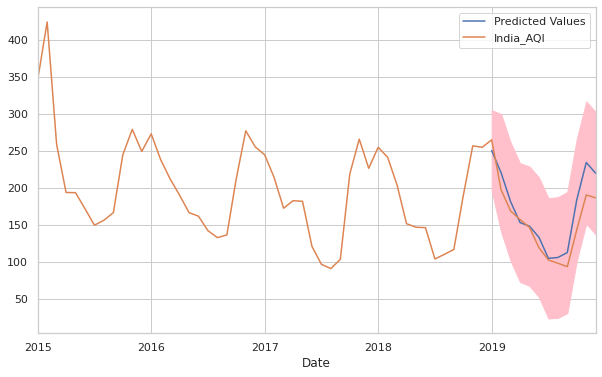

In [28]:
fig, ax= plt.subplots(figsize=(10,6))

#predict the next 12 months values to compare with the test dataset
forecasts = results.get_forecast(steps=12, dynamic=True)

#find the confidence intervals
confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

#plot the forecasted mean data for the next 12 months and the confidence interval
forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

#plotting the actual value from test data
test_data.plot(legend=True, ax=ax)

In [29]:
from sklearn.metrics import mean_squared_error

test= cities['India_AQI']['2019-01':'2019-12']
RMSE=np.sqrt(mean_squared_error(forecasts.predicted_mean,test))
print('RMSE = ',RMSE)

RMSE =  22.755117851345148


We see that the model has an RMSE of 22.75 on the test data set. Now, we can use this model to predict values into the future.

We'll be forecastig AQI values for 2021. However, 2020 yielded unexpected AQI values owing to the lockdown imposed due to COVID-19, as we saw earlier. So our prediction might have a wider margin of error to be considered.

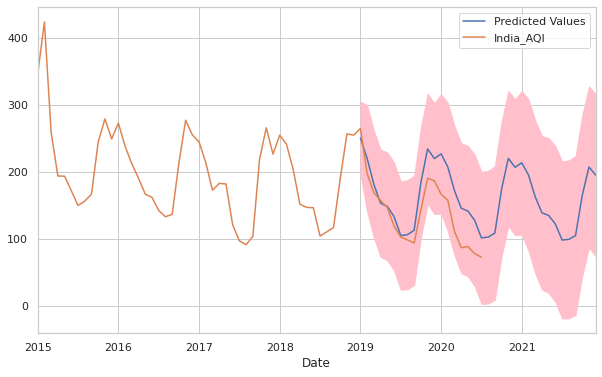

In [30]:
fig, ax= plt.subplots(figsize=(10,6))

forecasts = results.get_forecast(steps=36, dynamic=True)

confidence_intervals=forecasts.conf_int()
lower_limits = confidence_intervals.loc[:,'lower India_AQI']
upper_limits = confidence_intervals.loc[:,'upper India_AQI']

#plot the forecasted data
forecasts.predicted_mean.plot(legend=True, ax=ax, label ='Predicted Values')

#plot the confidence interval as the shaded area
plt.fill_between(confidence_intervals.index, lower_limits, upper_limits, color='pink')

#Plot India's AQI Data
cities['India_AQI'].plot(legend=True, ax=ax)